In [1]:
import torch
import warnings

warnings.filterwarnings("ignore")

from torch import nn
from common.conv2d_img2col import Conv2dImg2Col
import copy
import os
import pytorch_lightning as pl

os.chdir("/workspaces/conv2d_reimagined")

from experiments.conv2d_img2col_QAT import create_dummy_dataloader
from torch.quantization.quantize_fx import convert_fx

from src.models.dummy import DummyModel
from src.core.latency import (
    latency_cpu,
    latency_gpu,
    latency_cpu_profiler,
    latency_gpu_event,
)
from src.utils import basicconv_model, custom_conv_model, compare_models
from src.core.quant import setup_qat_for_model
from src.core.metric_writer import LatencyMetricsWriter


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [2]:
WARM_N = 10
BENCH_N = 100
writer = LatencyMetricsWriter("q_model_latency_metrics.csv")

In [2]:
def get_dummy_model_input(batch=4, replace_conv2d=False):
    model = DummyModel(replaced_conv=replace_conv2d)
    input = torch.randn(batch, 3, 64, 64, requires_grad=False)

    model.to(device)
    input = input.to(device)

    model.eval()
    lcpu = latency_cpu(model, input, warmup_n=10, benchmark_n=30)
    lgpu = latency_gpu(model, input, warmup_n=10, benchmark_n=30)
    lcpu_p1 = latency_cpu_profiler(model, input, warmup_n=10, benchmark_n=30)
    print(lcpu_p1.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))
    return model, input

## Simple Sequential - test with different kernel size

In [ ]:
batch = 2

model = nn.Sequential(
    Conv2dImg2Col(3, 16, kernel_size=3, stride=1, padding=1, bias=True),
    nn.ReLU(),
    Conv2dImg2Col(16, 32, kernel_size=3, stride=1, padding=1, bias=True),
    nn.ReLU(),
    Conv2dImg2Col(32, 64, kernel_size=3, stride=1, padding=1, bias=True),
)
model_ = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=True),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=True),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=True),
)
model_name = "Simple_Conv2dImg2Col_Network"
model_name_ = "Simple_Conv2d_Network"
input = torch.randn(batch, 3, 180, 320, requires_grad=False)

model.to(device)
input = input.to(device)

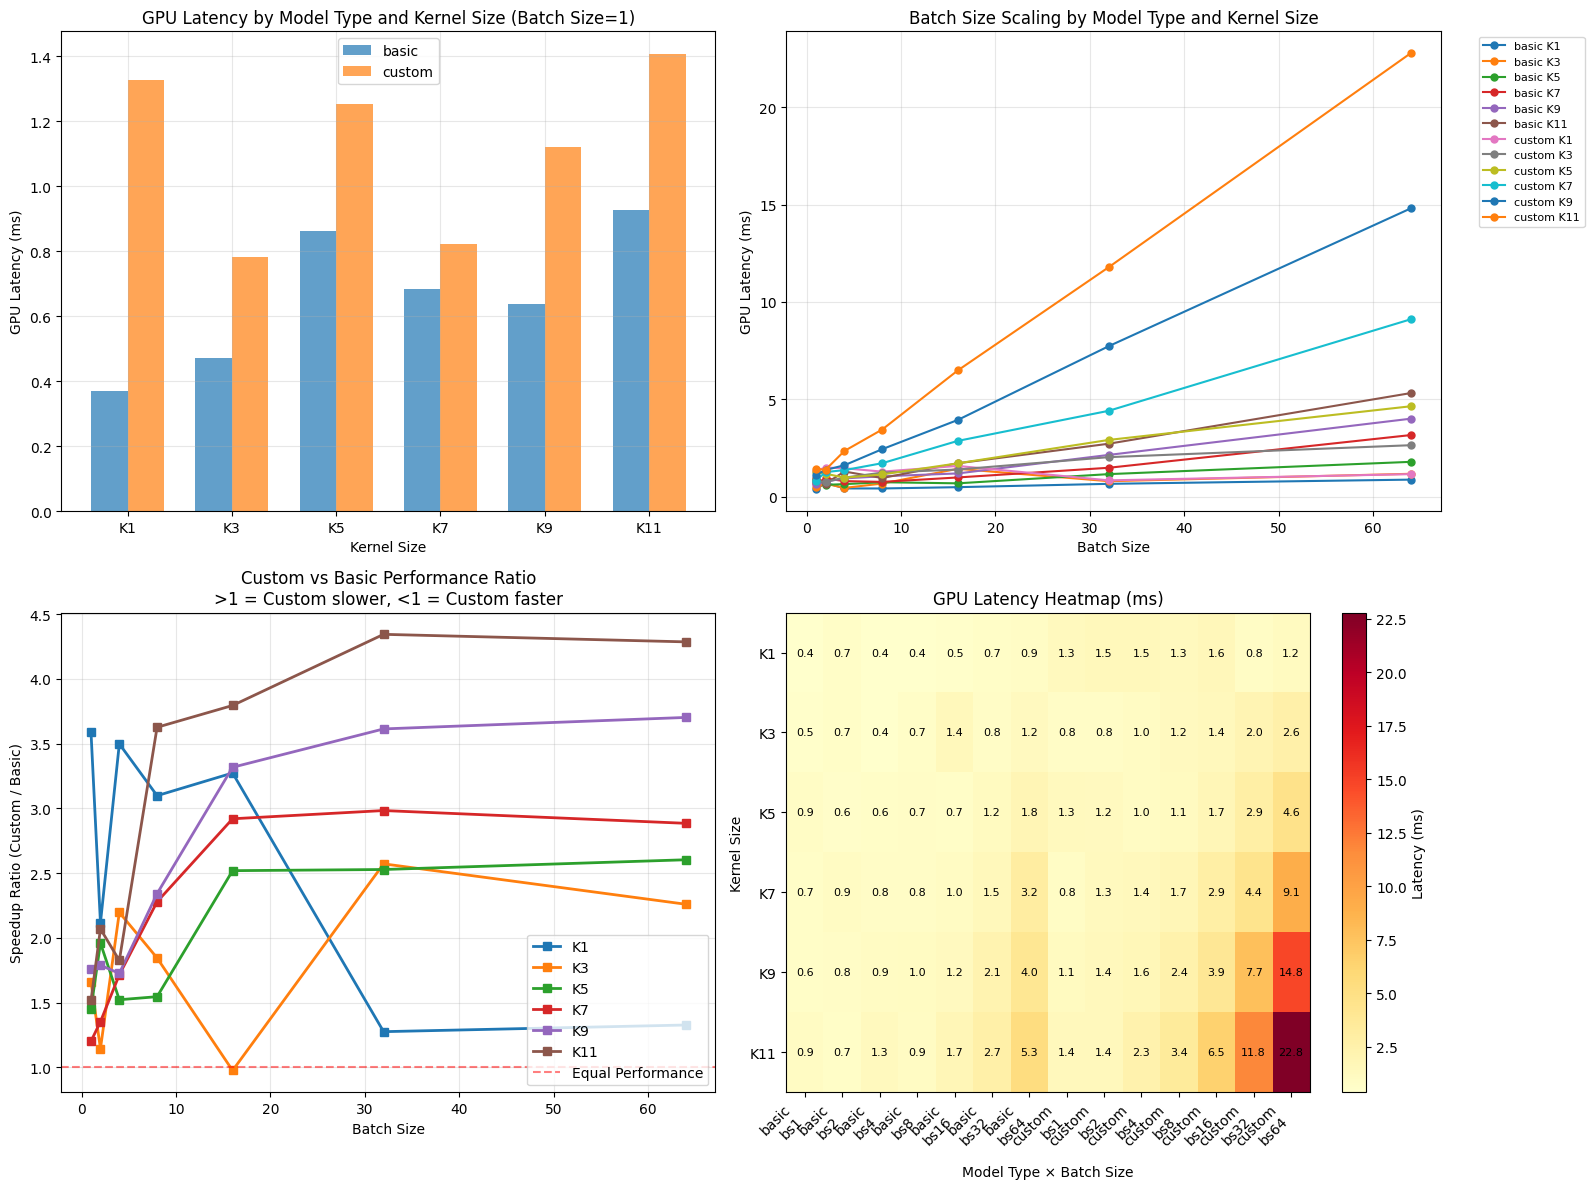

=== Performance Summary ===
BASIC Models: GPU=1.17ms, CPU=0.05ms
CUSTOM Models: GPU=3.26ms, CPU=0.12ms

=== Kernel Size Impact ===
Kernel Size 1: 0.93ms average GPU latency
Kernel Size 3: 1.10ms average GPU latency
Kernel Size 5: 1.44ms average GPU latency
Kernel Size 7: 2.16ms average GPU latency
Kernel Size 9: 3.12ms average GPU latency
Kernel Size 11: 4.51ms average GPU latency

=== Batch Size Impact ===
Batch Size 1: 0.89ms average GPU latency
Batch Size 2: 0.98ms average GPU latency
Batch Size 4: 1.10ms average GPU latency
Batch Size 8: 1.32ms average GPU latency
Batch Size 16: 2.03ms average GPU latency
Batch Size 32: 3.22ms average GPU latency
Batch Size 64: 5.95ms average GPU latency


In [2]:
import time
def eval_simple_sequential():
    writer = LatencyMetricsWriter("sequential_model_latency_dummy.csv")
    for key in ["custom_conv_model", "basicconv_model"]:
        for k in [1, 3, 5, 7, 9, 11]:
            if key == "custom_conv_model":
                model = custom_conv_model(k)
            else:
                model = basicconv_model(k)
            for bs in [1, 2, 4, 8, 16, 32, 64]:

                input = torch.randn(bs, 3, 32, 32, requires_grad=False)
                model.to(device)
                input = input.to(device)
                # collect cpu gpu stat for model
                lcpu_p1 = latency_cpu_profiler(
                    model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
                )
                gpu_mean_p1, gpu_std_p1 = latency_gpu(
                    model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
                )

                writer.record_metrics(
                    model=model,
                    model_name=f"{key}_k{k}_bs{bs}",
                    batch_size=input.shape[0],
                    precision="fp32",
                    input_shape=input.shape,
                    cpu_profiler=lcpu_p1,
                    gpu_latency=(gpu_mean_p1, gpu_std_p1),
                    notes=f"Simple Sequential model with {key} and kernel_size={k}",
                )
                del lcpu_p1
            # clean up
            del model
            del input
            torch.cuda.empty_cache()


def visualize_result(key):
    compare_models(
        "sequential_model_latency_dummy.csv", key
    )


# eval_simple_sequential()
visualize_result(key='latency_gpu_mean_ms')

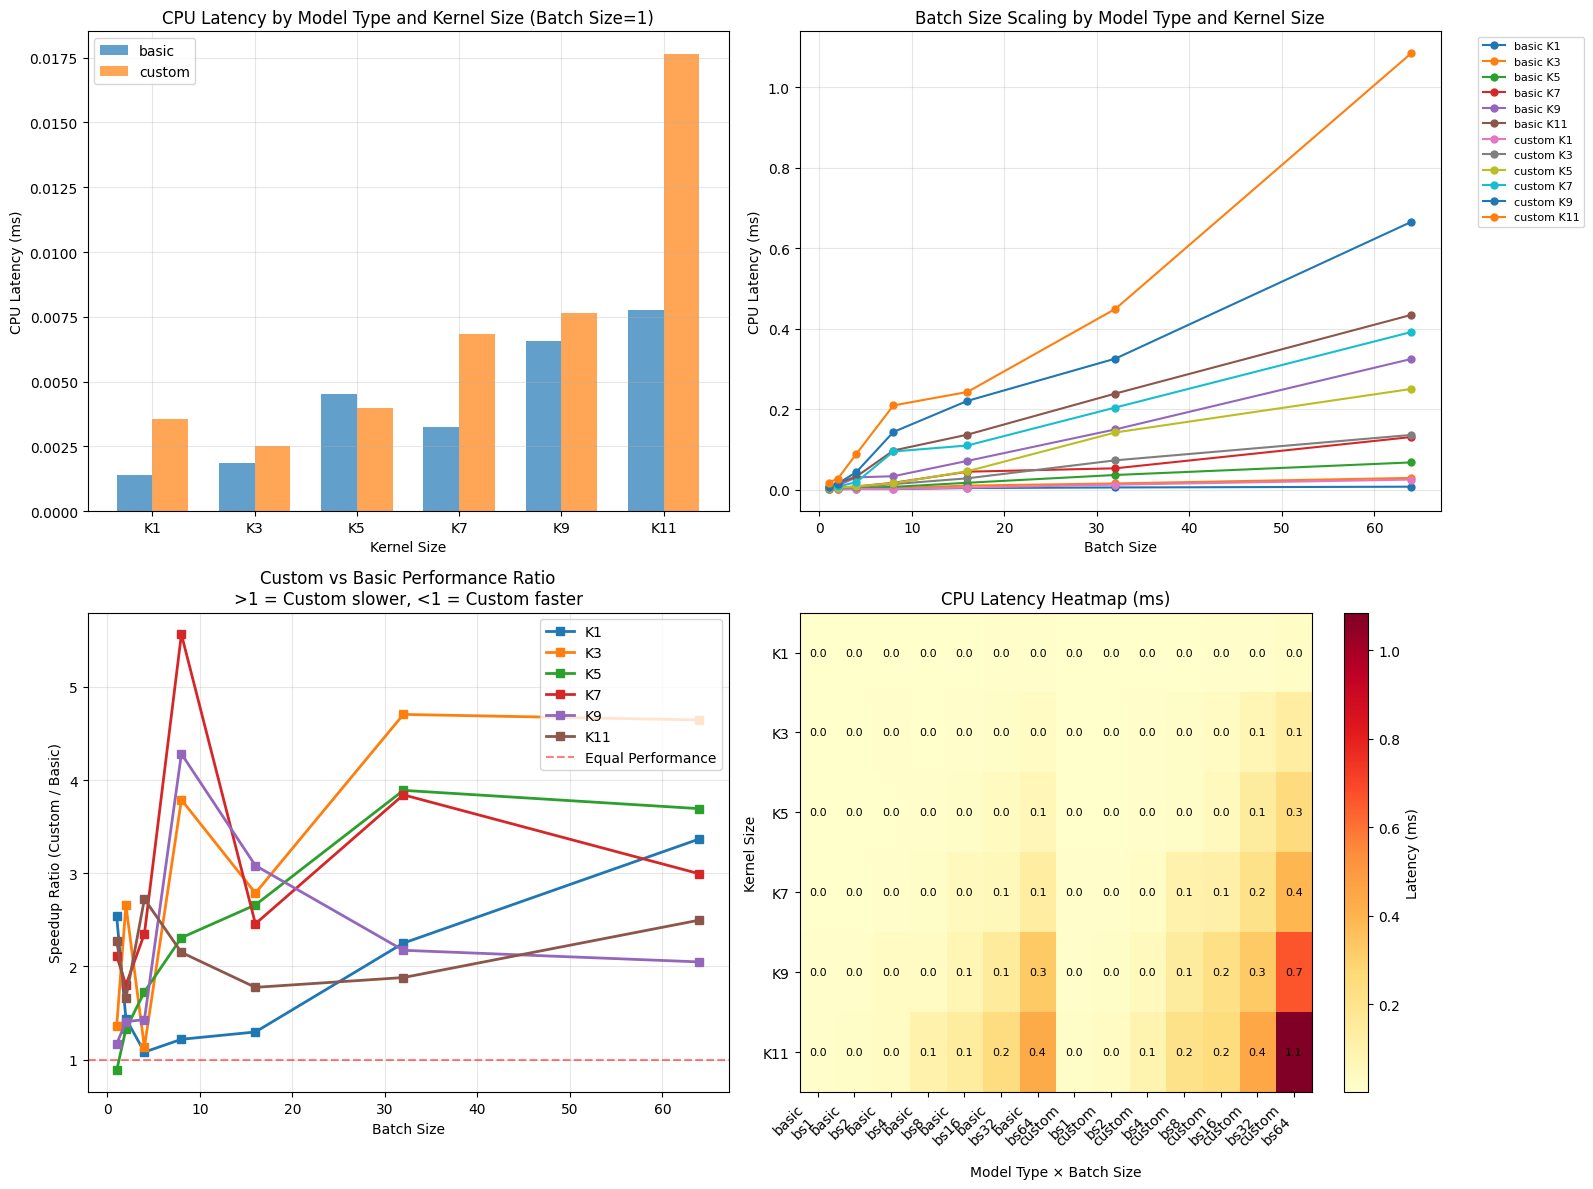

=== Performance Summary ===
BASIC Models: GPU=1.17ms, CPU=0.05ms
CUSTOM Models: GPU=3.26ms, CPU=0.12ms

=== Kernel Size Impact ===
Kernel Size 1: 0.01ms average CPU latency
Kernel Size 3: 0.02ms average CPU latency
Kernel Size 5: 0.04ms average CPU latency
Kernel Size 7: 0.08ms average CPU latency
Kernel Size 9: 0.15ms average CPU latency
Kernel Size 11: 0.22ms average CPU latency

=== Batch Size Impact ===
Batch Size 1: 0.01ms average CPU latency
Batch Size 2: 0.01ms average CPU latency
Batch Size 4: 0.02ms average CPU latency
Batch Size 8: 0.05ms average CPU latency
Batch Size 16: 0.08ms average CPU latency
Batch Size 32: 0.14ms average CPU latency
Batch Size 64: 0.30ms average CPU latency


In [3]:
visualize_result(key='latency_cpu_ms')

In [12]:
latency_gpu(model, input, warmup_n=10, benchmark_n=10)
latency_gpu_event(model, input, warmup=10, repeat=10)

Start GPU benchmark with input shape: torch.Size([2, 3, 320, 320]) cuda:0
7.003ms +- 3.361ms


(12.413007736206055, 5.0858612060546875)

In [5]:
latency_cpu(model, input, warmup_n=10, benchmark_n=30)

Start CPU benchmark with input shape: torch.Size([2, 3, 320, 320]) cpu
23.287ms +- 8.167ms


(23.287114333288628, 8.16671405879791)

In [13]:
model.to("cpu")
input = input.to("cpu")
print(input.device)
prof = latency_cpu_profiler(model, input, warmup_n=10, benchmark_n=30)
print(
    prof.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=15
    )
)

cpu
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                              Input Shapes  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------  
          model_inference         1.60%     343.000us       100.00%      21.477ms      21.477ms           0 b     -12.50 Mb             1                                                        []  
      Img2ColConvFunction         4.31%     926.000us        98.40%      21.134ms      21.134ms      12.50 Mb     -23.47 Mb             1                   [[2, 3, 320, 320], [16, 3, 3, 3], [16]]  
      

STAGE:2025-10-31 12:37:26 18839:18839 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-31 12:37:26 18839:18839 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-31 12:37:26 18839:18839 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


## Simple Model

In [3]:
model, input = get_dummy_model_input(16)
print("\n--- post training dynamic/weight_only quantization ---")

# config = get_default_qat_qconfig_mapping("x86") # qnnpack
prepared_model = copy.deepcopy(model)
prepared_model = setup_qat_for_model(prepared_model, input, config=None)
prepared_model.eval()
print()

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
53.059ms +- 3.258ms
Start GPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cuda:0
1.209ms +- 0.379ms


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")


--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
        aten::mkldnn_convolution        67.71%      37.652ms        68.03%      37.830ms      12.610ms      28.00 Mb           0 b             3  
                 aten::clamp_min        14.94%       8.309ms        14.94%       8.309ms       2.770ms      28.00 Mb      28.00 Mb             3  
                 model_inference         5.02%       2.789ms       100.00%      55.607ms      55.607ms           0 b     -84.00 Mb             1  
         aten::native_batch_norm         3.91%       2.172ms         4.00%       2.227ms     742.333us      28.00 Mb  

STAGE:2025-10-24 15:46:58 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:46:58 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:46:58 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [4]:
lcpu = latency_cpu(prepared_model, input, warmup_n=10, benchmark_n=30)
lcpu_p1 = latency_cpu_profiler(prepared_model, input, warmup_n=10, benchmark_n=30)

prepared_model.cpu()
save = convert_fx(prepared_model)
print("\n--- after  convert_fx ---")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
60.233ms +- 11.772ms

--- after  convert_fx ---


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:47:03 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:47:03 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:47:03 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
18.577ms +- 2.144ms


STAGE:2025-10-24 15:47:04 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:47:04 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:47:04 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [5]:
print(
    lcpu_p1.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                        model_inference        18.10%      12.006ms       100.00%      66.340ms      66.340ms           0 b     -91.77 Mb             1                                                                             

In [6]:
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                          Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                  model_inference         8.10%       1.749ms       100.00%      21.591ms      21.591ms           0 b      -7.19 Mb             1                                    []  
           quantized::conv2d_relu        49.47%      10.681ms        49.59%      10.706ms      10.706ms       4.00 Mb     -16.00 Mb             1        [[16, 32, 64, 64], [], [], []]  
           quantized::conv2d_relu        26.46%       5.712ms        2

#### Simple Model with replaced conv

In [5]:
model, input = get_dummy_model_input(16, replace_conv2d=True)
print("\n--- post training dynamic/weight_only quantization ---")

# config = get_default_qat_qconfig_mapping("x86") # qnnpack
prepared_model = copy.deepcopy(model)
prepared_model = setup_qat_for_model(prepared_model, input, config=None)
prepared_model.eval()
print()

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
101.033ms +- 16.026ms
Start GPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cuda:0
2.602ms +- 0.774ms


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:53:01 23946:23946 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:53:02 23946:23946 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:53:02 23946:23946 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     aten::copy_        47.92%      81.330ms        47.92%      81.330ms      10.166ms           0 b           0 b             8  
                        aten::mm        21.05%      35.730ms        21.05%      35.730ms      11.910ms      28.00 Mb      28.00 Mb             3  
                 model_inference        11.04%      18.738ms       100.00%     169.729ms     169.729ms           0 b    -212.31 Mb             1  
         aten::native_batch_norm         8.19%      13.896ms         8.27%      14.037ms       4.679ms      28.00 Mb  

/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [6]:
lcpu = latency_cpu(prepared_model, input, warmup_n=10, benchmark_n=30)
lcpu_p1 = latency_cpu_profiler(prepared_model, input, warmup_n=10, benchmark_n=30)

prepared_model.cpu()
save = convert_fx(prepared_model)
print("\n--- after  convert_fx ---")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
857.720ms +- 68.400ms


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:53:52 23946:23946 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:53:53 23946:23946 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:53:53 23946:23946 ActivityProfilerController.cpp:322] Completed Stage: Post Processing



--- after  convert_fx ---
Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
103.598ms +- 12.411ms


STAGE:2025-10-24 15:53:58 23946:23946 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:53:58 23946:23946 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:53:58 23946:23946 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [7]:
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                                Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------------------  
                  model_inference         1.83%       2.051ms       100.00%     111.845ms     111.845ms           0 b    -241.49 Mb             1                                                          []  
        aten::quantize_per_tensor         3.43%       3.832ms        26.74%      29.904ms      29.904ms      18.00 Mb     -54.00 Mb             1                       

##### Calibrated for static quant

In [7]:
model, input = get_dummy_model_input(16)
print("\n--- post training dynamic/weight_only quantization ---")

# config = get_default_qat_qconfig_mapping("x86") # qnnpack
prepared_model = copy.deepcopy(model)
prepared_model = setup_qat_for_model(prepared_model, input, config=None)
loader = create_dummy_dataloader()

prepared_model = prepared_model.to(device)
prepared_model.eval()
with torch.no_grad():
    for data, target in loader:  # dataloader transfer data to device
        prepared_model(data)

prepared_model.eval()
prepared_model.cpu()
save = convert_fx(prepared_model)
print("\n--- after  convert_fx ---")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
43.836ms +- 8.974ms
Start GPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cuda:0
1.574ms +- 0.554ms
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
        aten::mkldnn_convolution        68.80%      26.064ms        69.09%      26.174ms       8.725ms      28.00 Mb           0 b             3  
                 aten::clamp_min        13.59%       5.148ms        13.59%       5.148ms       1.716ms      28.00 Mb      28.00 Mb             3  
         aten::native_batch_norm         8.49%       3.215ms         8.58%       3.

STAGE:2025-10-24 15:47:17 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:47:17 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:47:17 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at ../aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(



--- after  convert_fx ---
Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
18.673ms +- 2.247ms


STAGE:2025-10-24 15:47:18 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:47:18 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:47:18 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [8]:
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                          Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                  model_inference         4.72%     867.000us       100.00%      18.361ms      18.361ms           0 b      -7.19 Mb             1                                    []  
           quantized::conv2d_relu        54.57%      10.019ms        54.62%      10.029ms      10.029ms       4.00 Mb     -16.00 Mb             1        [[16, 32, 64, 64], [], [], []]  
           quantized::conv2d_relu        22.96%       4.216ms        2

##### Export tests

In [21]:
print("start export  via tracing with shape: input =", input.shape)
save_traced = torch.jit.trace(save, input.cpu())

start export  via tracing with shape: input = torch.Size([16, 3, 64, 64])


In [22]:
lcpu_traced = latency_cpu_profiler(save_traced, input, warmup_n=10, benchmark_n=30)
print(
    lcpu_traced.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                          Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                  model_inference        27.22%      21.425ms       100.00%      78.712ms      78.712ms           0 b        -640 b             1                                    []  
                          forward         0.43%     335.000us        72.78%      57.287ms      57.287ms         640 b           0 b             1                 [[], [16, 3, 64, 64]]  
           quantized::conv2d_relu        37.29%      29.352ms        3

/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:19:22 12775:12775 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:19:22 12775:12775 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:19:22 12775:12775 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [25]:
save_scripted = torch.jit.script(save)
lcpu_save_scripted = latency_cpu_profiler(
    save_scripted, input, warmup_n=10, benchmark_n=30
)
print(
    lcpu_save_scripted.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                          Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                  model_inference        16.26%       7.230ms       100.00%      44.458ms      44.458ms           0 b        -640 b             1                                    []  
                          forward         1.99%     883.000us        83.74%      37.228ms      37.228ms         640 b        -160 b             1                 [[], [16, 3, 64, 64]]  
           quantized::conv2d_relu        44.57%      19.814ms        4

/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:21:00 12775:12775 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:21:00 12775:12775 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:21:00 12775:12775 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [ ]:
export_onnx(save, example_input, "traced")
torch.jit.save(save, "model-jit-trace.pt")
torch.cuda.empty_cache()
print("Model quantization complete!")
print("Models saved!")

# CamVidModel

In [8]:
from src.models.camvid_segmentation_multiclass import (
    get_dataloaders,
    CamVidModel,
    visualize_sample,
    visualize_data,
    train_val,
    save_load_torch_model,
)

DATA_DIR = "/workspaces/conv2d_reimagined/data/CamVid"

x_train_dir = os.path.join(DATA_DIR, "train")
y_train_dir = os.path.join(DATA_DIR, "trainannot")

x_valid_dir = os.path.join(DATA_DIR, "val")
y_valid_dir = os.path.join(DATA_DIR, "valannot")

x_test_dir = os.path.join(DATA_DIR, "test")
y_test_dir = os.path.join(DATA_DIR, "testannot")

train_loader, valid_loader, test_loader = get_dataloaders(
    x_train_dir, y_train_dir, x_valid_dir, y_valid_dir, x_test_dir, y_test_dir, bs=4
)

# Some training hyperparameters

EPOCHS = 1
T_MAX = EPOCHS * len(train_loader)
# Always include the background as a class
OUT_CLASSES = len(train_loader.dataset.CLASSES)

In [3]:
# visualize_data(x_train_dir, y_train_dir)

### Create and train simply

train and save

In [4]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
valid_metrics, test_metrics, trainer = train_val(
    model, train_loader, valid_loader, test_loader, max_epochs=EPOCHS
)
writer = LatencyMetricsWriter("q_model_latency_metrics.csv")
save_load_torch_model(model, path="camvid_model_fp32.pt")
# model_loaded = save_load_torch_model(model, save=False, path = 'camvid_model_fp32.pt')

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25

Epoch 0: 100%|██████████| 92/92 [00:56<00:00,  1.63it/s, v_num=13, valid_per_image_iou=0.561, valid_dataset_iou=0.560]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 92/92 [01:05<00:00,  1.41it/s, v_num=13, valid_per_image_iou=0.561, valid_dataset_iou=0.560]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 26/26 [00:12<00:00,  2.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'valid_per_image_iou': 0.5607734322547913, 'valid_dataset_iou': 0.5604749917984009}]
Testing DataLoader 0: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
[{'test_per_image_iou': 0.5147053003311157, 'test_dataset_iou': 0.5126190781593323}]


eval saved model

In [5]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model = save_load_torch_model(model, path="camvid_model_fp32.pt", save=False)
model.eval()

lcpu_p1 = latency_cpu_profiler(model, input, warmup_n=WARM_N, benchmark_n=BENCH_N)
gpu_mean_p1, gpu_std_p1 = latency_gpu(
    model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
)
valid_metrics, test_metrics, trainer = train_val(
    model,
    train_loader,
    valid_loader,
    test_loader,
    max_epochs=EPOCHS,
    fp16=True,
    train=False,
    test=True,
)
print(
    lcpu_p1.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)
# Record metrics for both models
metrics_p1 = writer.record_metrics(
    model=model,
    model_name="CamVidModel",
    batch_size=input.shape[0],
    precision="fp32",
    input_shape=input.shape,
    cpu_profiler=lcpu_p1,
    gpu_latency=(gpu_mean_p1, gpu_std_p1),
    notes="Original model before conversion",
    val_iou=valid_metrics[0]["valid_dataset_iou"],
    test_iou=test_metrics[0]["test_dataset_iou"],
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'valid_per_image_iou': 0.5607734322547913, 'valid_dataset_iou': 0.5604749917984009}]
Testing DataLoader 0: 100%|██████████| 59/59 [00:23<00:00,  2.47it/s]
[{'test_per_image_iou': 0.5147053003311157, 'test_dataset_iou': 0.5126190781593323}]


### FP16 trainig with mixed precision

train model

In [ ]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
valid_metrics, test_metrics, trainer = train_val(
    model,
    train_loader,
    valid_loader,
    test_loader,
    max_epochs=20,
    fp16=True,
    log_every_n_steps=5,
)

trainer.model.eval()
with torch.no_grad():
    save_load_torch_model(trainer.model, path="camvid_model_fp16.pt")

# model = save_load_torch_model(model, path = 'camvid_model_fp16.pt', save=False)
# model.half()
# print()

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
25.6 M    Traina

Epoch 19: 100%|██████████| 92/92 [01:00<00:00,  1.51it/s, v_num=0, valid_per_image_iou=0.783, valid_dataset_iou=0.782, train_per_image_iou=0.741, train_dataset_iou=0.732]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 92/92 [01:05<00:00,  1.40it/s, v_num=0, valid_per_image_iou=0.783, valid_dataset_iou=0.782, train_per_image_iou=0.741, train_dataset_iou=0.732]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]
[{'valid_per_image_iou': 0.7829864621162415, 'valid_dataset_iou': 0.7824925184249878}]


In [4]:
# load withou .half()
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model = save_load_torch_model(model, path="camvid_model_fp16.pt", save=False)
model.eval()

lcpu_p1 = latency_cpu_profiler(model, input, warmup_n=WARM_N, benchmark_n=BENCH_N)
gpu_mean_p1, gpu_std_p1 = latency_gpu(
    model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
)
valid_metrics, test_metrics, trainer = train_val(
    model,
    train_loader,
    valid_loader,
    test_loader,
    max_epochs=EPOCHS,
    fp16=True,
    train=False,
    test=True,
)
# Record metrics for both models
metrics_p1 = writer.record_metrics(
    model=model,
    model_name="CamVidModel",
    batch_size=input.shape[0],
    precision="fp16-trained",
    input_shape=input.shape,
    cpu_profiler=lcpu_p1,
    gpu_latency=(gpu_mean_p1, gpu_std_p1),
    notes="",
    val_iou=valid_metrics[0]["valid_dataset_iou"],
    test_iou=test_metrics[0]["test_dataset_iou"],
)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 26/26 [00:19<00:00,  1.30it/s]
[{'valid_per_image_iou': 0.7829864621162415, 'valid_dataset_iou': 0.7824925184249878}]


0.7824925184249878

here when actually .half() - acc drop ?

In [4]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
writer = LatencyMetricsWriter("q_model_latency_metrics.csv")

input, gt = next(iter(valid_loader))
model = save_load_torch_model(model, path="camvid_model_fp16.pt", save=False)
model.eval()
model.half()
valid_metrics, test_metrics, trainer = train_val(
    model,
    train_loader,
    valid_loader,
    test_loader,
    max_epochs=EPOCHS,
    fp16=True,
    train=False,
)

lcpu_p1 = None
gpu_mean_p1, gpu_std_p1 = latency_gpu(
    model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
)

# Record metrics for both models
metrics_p1 = writer.record_metrics(
    model=model,
    model_name="CamVidModel",
    batch_size=input.shape[0],
    precision="fp16-half",
    input_shape=input.shape,
    cpu_profiler=lcpu_p1,
    gpu_latency=(gpu_mean_p1, gpu_std_p1),
    notes="slow_conv2d_cpu not implemented for 'Half'",
    val_iou=valid_metrics[0]["valid_dataset_iou"],
    test_iou=test_metrics[0]["test_dataset_iou"],
)

CamVidModel(
  (model): FPN(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

### Create model again

In [3]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
# model_loaded = torch.nn.Sequential(*(list(model_loaded.children())[:-1]))
input, gt = next(iter(valid_loader))

In [9]:
# lcpu = latency_cpu(model, input, warmup_n=WARM_N, benchmark_n=BENCH_N)
# lgpu = latency_gpu(model, input, warmup_n=WARM_N, benchmark_n=BENCH_N)
# lcpu_p1 = latency_cpu_profiler(model, input, warmup_n=WARM_N, benchmark_n=BENCH_N)

# print()

### Ebable TF32 AND TRAIN / VAL / LATENCY

In [5]:
# Enable TF32 for matrix multiplications
torch.backends.cuda.matmul.allow_tf32 = True
# Enable TF32 for cuDNN (convolution operations)
torch.backends.cudnn.allow_tf32 = True

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
valid_metrics, test_metrics, trainer = train_val(
    model, train_loader, valid_loader, test_loader, max_epochs=EPOCHS
)
writer = LatencyMetricsWriter("q_model_latency_metrics.csv")
save_load_torch_model(model, path="camvid_model_tf32.pt")

Start GPU benchmark with input shape: torch.Size([4, 3, 384, 480]) cuda:0
58.306ms +- 6.759ms



In [ ]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model = save_load_torch_model(model, path="camvid_model_tf32.pt", save=False)
model.eval()

lcpu_p1 = latency_cpu_profiler(model, input, warmup_n=WARM_N, benchmark_n=BENCH_N)
gpu_mean_p1, gpu_std_p1 = latency_gpu(
    model, input, warmup_n=WARM_N, benchmark_n=BENCH_N
)
valid_metrics, test_metrics, trainer = train_val(
    model,
    train_loader,
    valid_loader,
    test_loader,
    max_epochs=EPOCHS,
    fp16=True,
    train=False,
    test=True,
)
# Record metrics for both models
metrics_p1 = writer.record_metrics(
    model=model,
    model_name="CamVidModel",
    batch_size=input.shape[0],
    precision="tf32",
    input_shape=input.shape,
    cpu_profiler=lcpu_p1,
    gpu_latency=(gpu_mean_p1, gpu_std_p1),
    notes="Original model in TF32 before conversion",
    val_iou=valid_metrics[0]["valid_dataset_iou"],
    test_iou=test_metrics[0]["test_dataset_iou"],
)

### Quantization


#### Quantize without calibration

Quantize all layers

In [ ]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model = save_load_torch_model(model, path="camvid_model_fp32.pt", save=False)
model.eval()

prepared_model = copy.deepcopy(model)
prepared_model.eval()
prepared_model = setup_qat_for_model(
    prepared_model, input, config=None
)  # cfg is default
prepared_model.cpu()
save = convert_fx(prepared_model)
save_load_torch_model(model, path="camvid_model_int8.pt")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

print(
    lcpu_p1.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)
print("\n--- after  convert_fx ---")
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)


--- after  convert_fx ---
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                               Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------------------  
                  model_inference         3.40%      29.317ms       100.00%     862.018ms     862.018ms           0 b    -691.00 Mb             1                                                         []  
                quantized::conv2d        13.24%     114.128ms        13.25%     114.248ms      38.083ms      22.50 Mb     -90.00 Mb             3

dont quantize selected layers

Example how select layers that we do /dont quantize

In [4]:
# do not quantize first / last layers
dont_quantize = [
    "model.model.encoder.conv1",
    "model.model.encoder.bn1",
    "model.model.encoder.relu",
    "model.model.encoder.maxpool",
    "model.model.segmentation_head",
]

from torch.ao.quantization import get_default_qconfig, QConfigMapping

my_qconfig = get_default_qconfig("x86")
qconfig_mapping = QConfigMapping()
qconfig_mapping = qconfig_mapping.set_global(my_qconfig)

# Specify which layers to SKIP quantization for by setting their qconfig to None
# You can do this by module name or type:
for layer_name in dont_quantize:
    qconfig_mapping = qconfig_mapping.set_module_name(layer_name, None)
config = qconfig_mapping

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model = save_load_torch_model(model, path="camvid_model_fp32.pt", save=False)
model.eval()

prepared_model = copy.deepcopy(model)
prepared_model.eval()
prepared_model = setup_qat_for_model(prepared_model, input, config=config)
prepared_model.cpu()
save = convert_fx(prepared_model)
save_load_torch_model(model, path="camvid_model_int8-partial.pt")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

print(
    lcpu_p1.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)
print("\n--- after  convert_fx ---")
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

In [22]:
print(input.dtype)
print(save(input).dtype)
print(save)

torch.uint8
torch.float32
GraphModule(
  (model): Module(
    (encoder): Module(
      (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=1.0, zero_point=0, padding=(3, 3))
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Module(
        (0): Module(
          (conv1): QuantizedConvReLU2d(64, 128, kernel_size=(1, 1), stride=(1, 1), scale=1.0, zero_point=0)
          (conv2): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1), groups=32)
          (conv3): QuantizedConv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), scale=1.0, zero_point=0)
          (downsample): Module(
            (0): QuantizedConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), scale=1.0, zero_point=0)
          )
        )
        (1): Module(
          (conv1): QuantizedConvReLU2d(256, 128, kernel_size=(1, 1), stride=(1, 1), scale=1.0, zero_point=0)
          (conv2): QuantizedC

##### Latency MetricWriter

#### QAT

In [4]:
from torch.ao.quantization import get_default_qat_qconfig_mapping

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model = save_load_torch_model(model, path="camvid_model_fp32.pt", save=False)
model.eval()


config = get_default_qat_qconfig_mapping("x86")
# fbgemm (onednn), qnnpack (xnnpack)
prepared_model = copy.deepcopy(model)
prepared_model.eval()
prepared_model = prepared_model.setup_qat(input, config)
prepared_model.cpu()

CamVidModel(
  (model): GraphModule(
    (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
    (encoder): Module(
      (conv1): ConvReLU2d(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): ReLU(inplace=True)
      )
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Module(
        (0): Module(
          (conv1): ConvReLU2d(
            (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
          )
          (conv2): ConvReLU2d(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=

In [5]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, callbacks=[])
trainer.fit(
    prepared_model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)
trainer.model.model.eval()
trainer.model.model.cpu()
save = convert_fx(trainer.model.model.eval())

# here dirty replacement trick to avoid changing too much code

# save.encoder.conv1[0].weight
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
# model_loaded = torch.nn.Sequential(*(list(model_loaded.children())[:-1]))
input, gt = next(iter(valid_loader))
model.eval()
model.model = save

model(input.cpu())
save_load_torch_model(model, path="camvid_model_int8-qat.pt")

lcpu_p2 = latency_cpu_profiler(model, input, warmup_n=10, benchmark_n=30)

print(
    lcpu_p1.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)
print("\n--- after  convert_fx ---")
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params | Mode
-----------------------------------------------
0 | model   | GraphModule | 25.6 M | eval
1 | loss_fn | DiceLoss    | 0      | eval
-----------------------------------------------
25.5 M    Trainable params
34.1 K    Non-trainable params
25.6 M    Total params
102.221   Total estimated model params size (MB)
275       Modules in train mode
102       Modules in eval mode


Epoch 0: 100%|██████████| 92/92 [01:03<00:00,  1.46it/s, v_num=10, valid_per_image_iou=0.392, valid_dataset_iou=0.391]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 92/92 [01:14<00:00,  1.24it/s, v_num=10, valid_per_image_iou=0.392, valid_dataset_iou=0.391]


## With Replaced Conv Block

In [3]:
from experiments.common.replace_conv_resnet import replace_conv2d_with_custom
from copy import deepcopy

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
# model_loaded = torch.nn.Sequential(*(list(model_loaded.children())[:-1]))
input, gt = next(iter(valid_loader))
input = input[0][None, ...]

input = input.cuda()
model.cuda()
forwarded = model(input)
torch.cuda.empty_cache()

In [4]:
model.cpu()
print(model.model.encoder.conv1)
replace_conv2d_with_custom(model)
print(model.model.encoder.conv1)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2dImg2Col(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [5]:
model(input.cpu())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11520x1152 and 36x128)

In [5]:
model(input)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [16]:
model.cuda()
forwarded_custom = model(input)

assert torch.allclose(forwarded, forwarded_custom, atol=1e-1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11520x1152 and 36x128)

In [10]:
forwarded[0, 0, 0, 0], forwarded_custom[0, 0, 0, 0]

(tensor(0.2955, device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(1.5659, device='cuda:0', grad_fn=<SelectBackward0>))

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2dImg2Col(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [7]:
model_custom_conv.cuda()
model_custom_conv(input.cuda())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11520x1152 and 36x128)

Simple eval latency with replaced conv

In [8]:
torch.cuda.empty_cache()

In [9]:
lcpu = latency_cpu(model_custom_conv, input, warmup_n=WARM_N, benchmark_n=BENCH_N)
lgpu = latency_gpu(model_custom_conv, input, warmup_n=WARM_N, benchmark_n=BENCH_N)
lcpu_p1 = latency_cpu_profiler(
    model_custom_conv, input, warmup_n=WARM_N, benchmark_n=BENCH_N
)
print(lcpu_p1.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))

print()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11520x1152 and 36x128)